<a href="https://colab.research.google.com/github/dubeyabhi07/hands-on-scikit-learn/blob/master/costComplexityPruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

mnist = fetch_openml('mnist_784', cache=False)

In [ ]:
import pandas as pd
mnist_df = pd.DataFrame(mnist.data, columns=mnist.feature_names)

X = mnist_df[0:5000]
Y = mnist.target[0:5000]
X.head(5)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,147.0,252.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X)
X_scaled=scaler.transform(X)

In [ ]:
from sklearn.decomposition import PCA
pca=PCA(n_components=0.98)         # retaining 98% variation
pca.fit(X_scaled) 
X_pca=pca.transform(X_scaled) 
#let's check the shape of X_pca array
print(X_pca.shape)
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca,Y,test_size=0.2, random_state=30, stratify=Y)

(5000, 382)


In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=0)
path = tree.cost_complexity_pruning_path(X_train_pca, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

print(ccp_alphas.shape)
print(impurities.shape)

(426,)
(426,)


[]

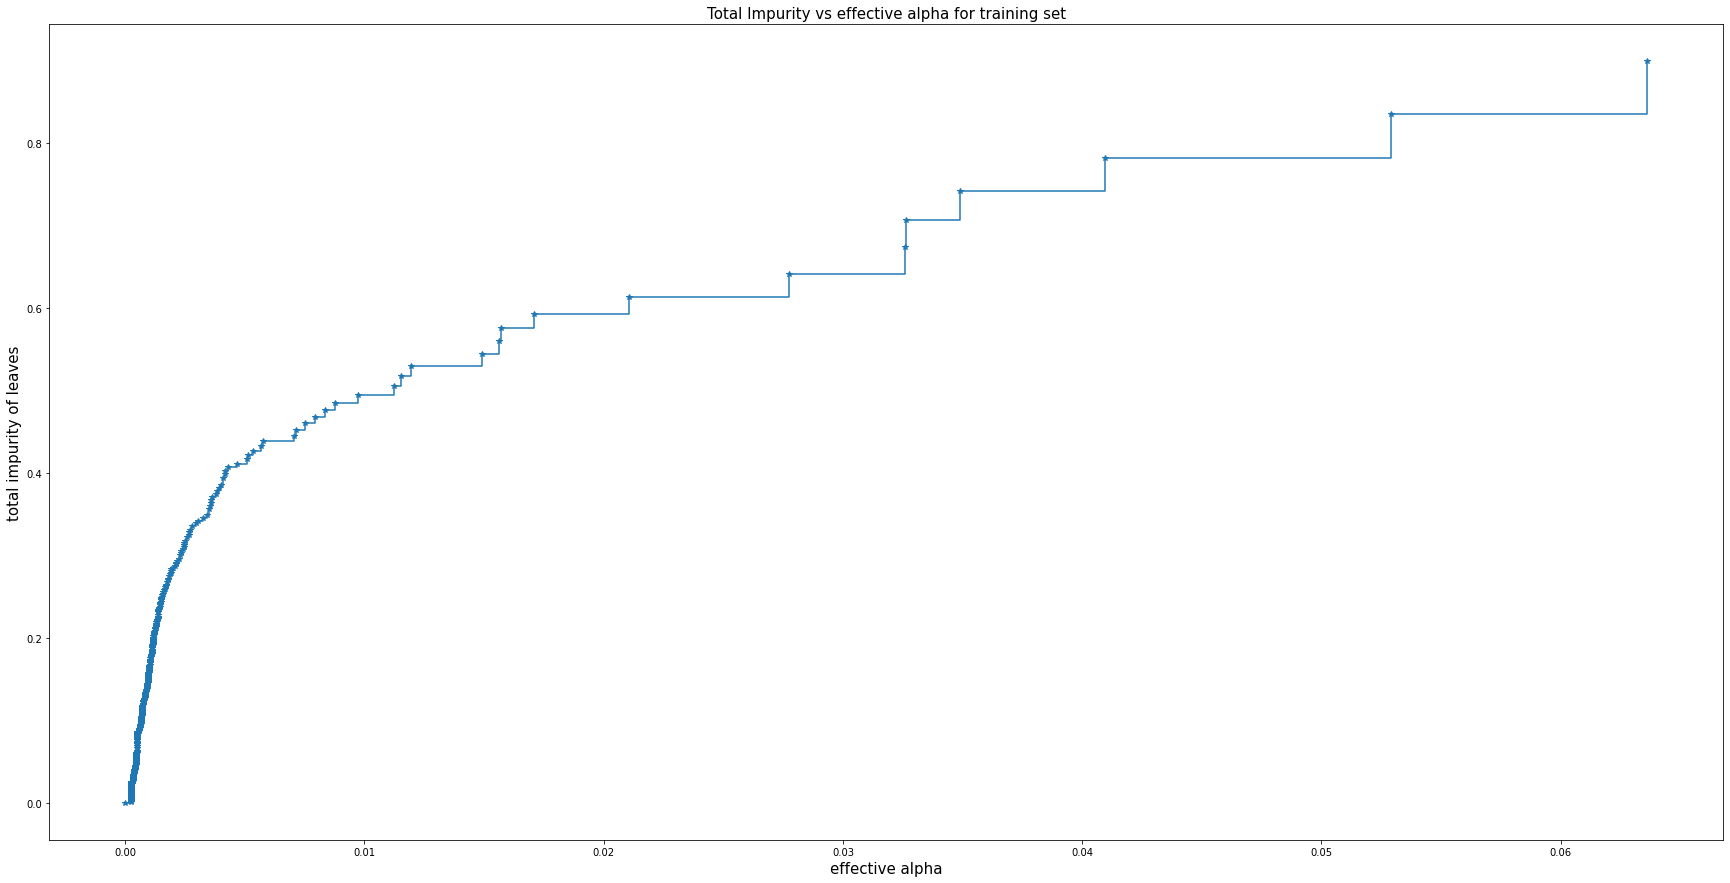

In [ ]:
plt.figure(figsize=(30,15))
plt.plot(ccp_alphas, impurities, marker = "*",drawstyle="steps-post")
plt.xlabel("effective alpha", fontsize = 15)
plt.ylabel("total impurity of leaves", fontsize = 15)
plt.title("Total Impurity vs effective alpha for training set", fontsize =15)
plt.plot()

In [ ]:
trees = []
for ccp_alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    tree.fit(X_train_pca, y_train)
    print(".",end ="")
    trees.append(tree)

..........................................................................................................................................................................................................................................................................................................................................................................................................................................

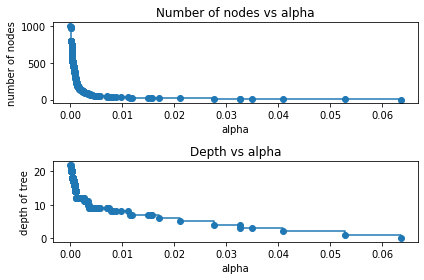

In [ ]:
node_counts = [clf.tree_.node_count for clf in trees]
depth = [clf.tree_.max_depth for clf in trees]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

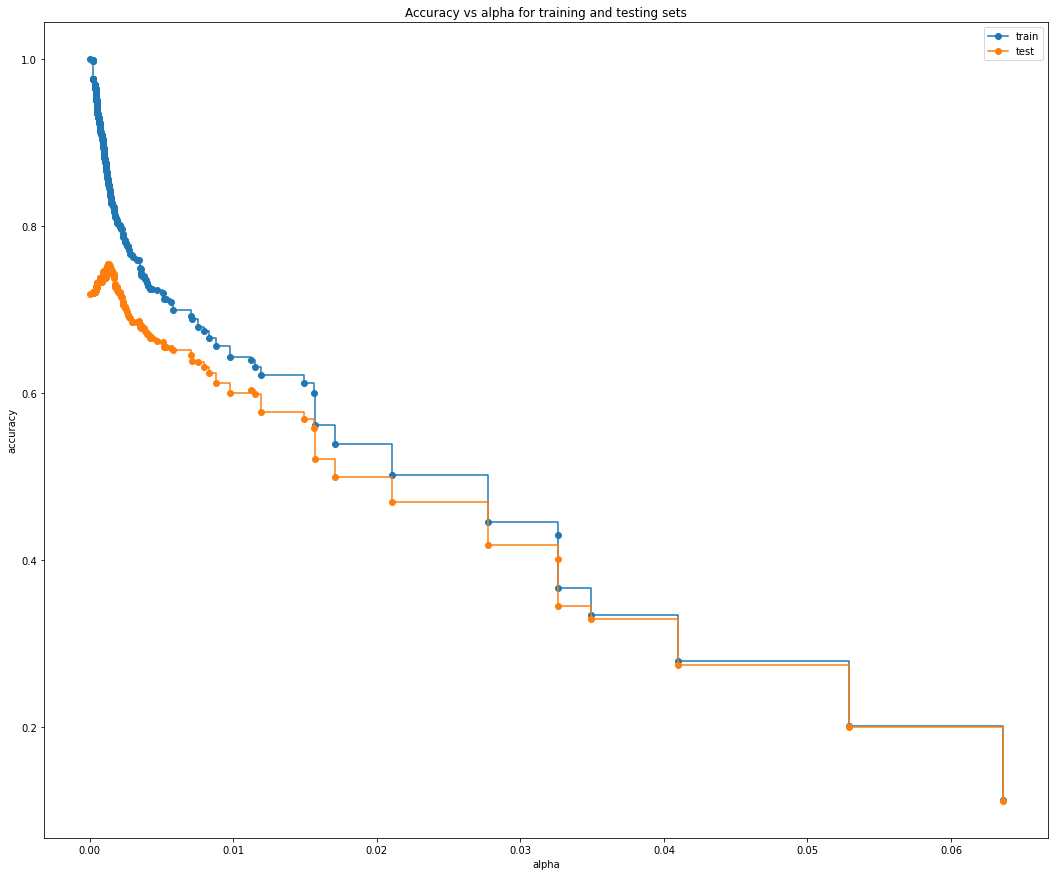

In [ ]:
train_scores = [clf.score(X_train_pca, y_train) for clf in trees]
test_scores = [clf.score(X_test_pca, y_test) for clf in trees]
plt.figure(figsize=(18,15))
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.title("Accuracy vs alpha for training and testing sets")
plt.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
plt.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
plt.legend()
plt.show()

In [ ]:
import numpy as np
ind = np.argmax(test_scores)
print("best alpha for test_set : ",ccp_alphas[ind])
print("best achievable accuracy with decision tree : ",test_scores[ind])
print("accuracy of train_set at best accuracy of test_set : ",train_scores[ind])

best alpha for test_set :  0.0012993421052631578
best achievable accuracy with decision tree :  0.755
accuracy of train_set at best accuracy of test_set :  0.85025


0.755
0.7528138220999464


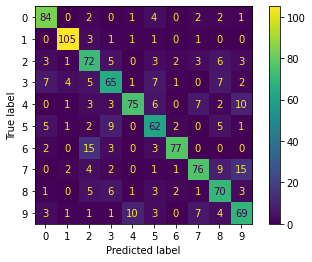

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
best = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alphas[ind])
best.fit(X_train_pca, y_train)
x = plot_confusion_matrix(best, X_test_pca, y_test,values_format = 'd')
print(metrics.accuracy_score(y_test,best.predict(X_test_pca)))
print(metrics.f1_score(y_test,best.predict(X_test_pca),average='macro'))

- Alpha is sensitive to the data, if we do cross validation, accuracy will change same alpha but different parts.
- This can be verified by doing cross validation on above alpha.  
- The above method is not ideal for selecting best alpha as we might overfit the test data. Ideally we should not see test data before making our model ready for test.


In [ ]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(best,{},cv=10,scoring='accuracy', return_train_score=False)

grid.fit(X_train_pca, y_train)

# examine the best model
import pandas as pd
df = pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,1.999252,0.056786,0.001544,0.000249,{},0.7325,0.795,0.7225,0.7275,0.7425,0.7325,0.7375,0.7325,0.7325,0.73,0.7385,0.0195,1


- Using the grid search with CCP

In [ ]:
params = {'ccp_alpha':ccp_alphas}
validationGrid = GridSearchCV(best,params,cv=5,scoring='accuracy', return_train_score=False)
validationGrid.fit(X_train_pca, y_train)
print("---------------------------------------------------------------------------------")
# examine the best model
print(validationGrid.best_score_)
print(validationGrid.best_params_)
print(validationGrid.best_estimator_)

---------------------------------------------------------------------------------
0.7344999999999999
{'ccp_alpha': 0.0015348927875243647}
DecisionTreeClassifier(ccp_alpha=0.0015348927875243647, class_weight=None,
                       criterion='gini', max_depth=None, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=0, splitter='best')


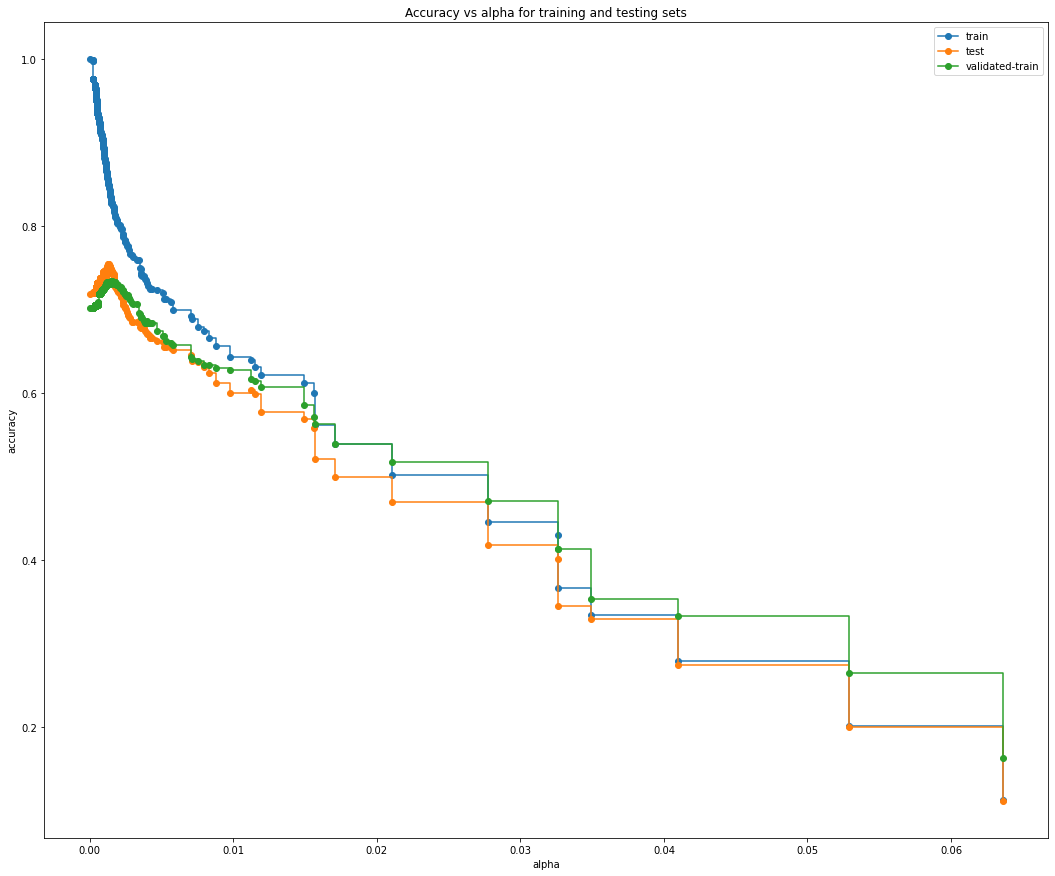

In [ ]:
train_scores = [clf.score(X_train_pca, y_train) for clf in trees]
test_scores = [clf.score(X_test_pca, y_test) for clf in trees]
plt.figure(figsize=(18,15))
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.title("Accuracy vs alpha for training and testing sets")
plt.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
plt.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
plt.plot(ccp_alphas,validationGrid.cv_results_['mean_test_score'],marker = 'o',label="validated-train",drawstyle="steps-post")
plt.legend()
plt.show()

0.745
0.7421563758237856


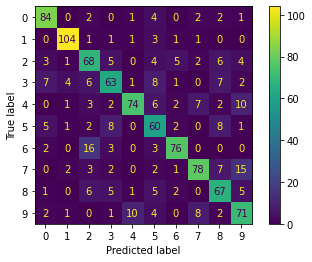

In [ ]:
x = plot_confusion_matrix(validationGrid.best_estimator_, X_test_pca, y_test,values_format = 'd')
print(metrics.accuracy_score(y_test,validationGrid.best_estimator_.predict(X_test_pca)))
print(metrics.f1_score(y_test,validationGrid.best_estimator_.predict(X_test_pca),average='macro'))

## We have trained 2 models
- One with cross validatation that gives accuracy of 74% with test data.
- One by seelcting alpha after seeing predictions on test data. It gives 75.5% accuracy.

#### Lets introduce new data set for prediction and see which model performs better and verify whether the first model overfits the test data.  

In [ ]:
X_new = mnist_df[10000:15000]
y_new = mnist.target[10000:15000]
X_scaled_new = scaler.transform(X_new)
X_pca_new = pca.transform(X_scaled_new) 

## Accuracy with cross validated model : 

In [ ]:
print(metrics.accuracy_score(y_new,validationGrid.best_estimator_.predict(X_pca_new)))
print(metrics.f1_score(y_new,validationGrid.best_estimator_.predict(X_pca_new),average='macro'))

0.7096
0.7071261289750453


## Accuracy with other model :

In [ ]:
print(metrics.accuracy_score(y_new,best.predict(X_pca_new)))
print(metrics.f1_score(y_new,best.predict(X_pca_new),average='macro'))

0.7142
0.7118589321579104
